# BIOSTAT615 Midterm Project - Fall 2021

## Introduction

This midterm project aims to implement open-ended methods to <u>***classify*** </u> and <u>***cluster***</u> widely known hand-written digit database, called MNIST database. 

This document describes how you can read MNIST dataset in R, how you can perfom simple classification tasks, and described how you can implement your own classification and clustering tasks. 

To complete your midterm project, you will need to take the following steps:
1. Copy this document for your own version for editing
2. Rename the document title to start with your own name: for example "John Doe - BIOSTAT615 Midterm Project - Fall 2021".
3. Read this document carefully to understand what are required and recommended tasks
4. Complete the required (and optional) tasks
5. Write your own report in your copy of notebook directly
6. Share your copy of the notebook with instructors (hmkang@umich.edu , ylzhong@umich.edu) as viewers (make sure that you do not share it with anyone else), and submit the URL to the notebook in Canvas.

You should be able to use Markdown language to write your own report. See [Markdown Guide](https://colab.research.google.com/notebooks/markdown_guide.ipynb) to learn how to modify your copy of this report using Markdown. You may also want to read [LaTeX Tutorial](https://en.wikibooks.org/wiki/LaTeX/Mathematics) to learn how to write mathematical equations in your report (or you can import equations as external images).

## Background

This section introduces what the MNIST dataset looks like, and explains how you can use them for your project.

### Preambles

First, let's try to load some R packages we will use for some of the example exercises.

In [1]:
# install.packages("glmnet") ## glmnet will be used as a example classification
# install.packages("tictoc") ## tictoc will be used for evaluating time
library(ggplot2)
library(glmnet)
library(tictoc)
library(dplyr)

Loading required package: Matrix
Loaded glmnet 4.1-3

Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



### Loading MNIST dataset

[MNIST](http://yann.lecun.com/exdb/mnist/) is a widely recognized databases of handwritten digits, containing thousands of labeled images in a standardized form. This data has been one of the gold-standard dataset to evaluate various machine learning methods. In this project, we will NOT require implement any machine learning or deep learning methods, but will use these data as an easy-to-visualize high-dimensional data. 

The code fragment below will load train (n=60,000) and test (n=10,000) images and labels (0 to 9), and visualize the images to improve your understanding. First, we will download these data from the web 

In [2]:
## DO NOT MODIFY THIS CELL
## set up the location of MNIST files
baseUrl = "http://yann.lecun.com/exdb/mnist/"
trainXf = "train-images-idx3-ubyte.gz"  ## train images
trainYf = "train-labels-idx1-ubyte.gz"  ## train labels
testXf = "t10k-images-idx3-ubyte.gz"    ## test images
testYf = "t10k-labels-idx1-ubyte.gz"    ## test labels

In [3]:
## DO NOT MODIFY THIS CELL
## Download MNIST data
filenames = c(trainXf, trainYf, testXf, testYf)
for(fn in filenames) { 
  if ( !file.exists(fn) ) { ## skip download if already exists
    system(paste0("wget ",baseUrl, fn),intern=TRUE)
  }
}

In [4]:
## DO NOT MODIFY THIS CELL
## verify the downloaded files
print(system("ls -l",intern=TRUE))
## Below is what you are expected to see when run this cell

 [1] "total 24088"                                                                                            
 [2] "-rw-r--r--  1 kailin  staff   120342 11 23 02:24 11.23_v1"                                              
 [3] "-rw-r--r--  1 kailin  staff    86884 11 22 23:13 1122.ipynb"                                            
 [4] "-rw-r--r--  1 kailin  staff    87945 11 22 23:11 1a_done.ipynb"                                         
 [5] "-rw-r--r--  1 kailin  staff   106042 11 19 18:30 2a_done.ipynb"                                         
 [6] "-rw-r--r--@ 1 kailin  staff   120342 11 23 02:24 Kailin_Wang_BIOSTAT615_Midterm_Project_Fall_2021.ipynb"
 [7] "-rw-r--r--@ 1 kailin  staff  1648877 11 12 19:31 t10k-images-idx3-ubyte.gz"                             
 [8] "-rw-r--r--@ 1 kailin  staff     4542 11 12 19:32 t10k-labels-idx1-ubyte.gz"                             
 [9] "-rw-r--r--@ 1 kailin  staff  9912422 11 12 19:31 train-images-idx3-ubyte.gz"                            
[

The download data is a binary file, and it follows a specific format described in the [original web site](http://yann.lecun.com/exdb/mnist/). To help you get started with this data, an example function to load this data is provided below. You do not have to understand how this function works. 

In [5]:
## DO NOT MODIFY THIS CELL
#' readMNIST() - Function to read MNIST images/labels
#' @param filename - Path to the local binary file
#' @return 1-d (label) or 3-d (images) arrays of MNIST data
readMNIST = function(filename) {
  con = gzfile(filename,"rb")
  hdr = readBin(con, integer(), n=2, endian="big") ## read one byte to figure out file type
  if ( hdr[1] == 2051 ) {         ## 2051 is a magic number for image files
    nxy = readBin(con, integer(), n=2, endian="big")  
    return ( array( readBin(con, integer(), signed=FALSE, size=1, n=hdr[2]*nxy[1]*nxy[2], endian="big"), dim=c(nxy[1],nxy[2],hdr[2]) ) )
  } else if ( hdr[1] == 2049 ) {  ## 2049 is a magic number for label files
    return ( readBin(con, integer(), signed=FALSE, size=1, n=hdr[2], endian="big") )
  } else {
    stop(paste0("Cannot recognize the magic number ", hdr[1]))
  }
}

In [6]:
## DO NOT MODIFY THIS CELL
train.X = readMNIST(trainXf)  ## read training images
train.Y = readMNIST(trainYf)  ## read training labels
print(dim(train.X))           ## print the dimension of training images (3-d array)
print(length(train.Y))        ## print the dimension of training labels

[1]    28    28 60000
[1] 60000


In [7]:
## DO NOT MODIFY THIS CELL
test.X = readMNIST(testXf)  ## read test images
test.Y = readMNIST(testYf)  ## read test labels
print(dim(test.X))          ## print the dimension of test images
print(length(test.Y))       ## print the dimension of test labels

[1]    28    28 10000
[1] 10000


     [,1] [,2] [,3] [,4] [,5] [,6]
[1,]    0    0    0  177  253   47
[2,]    0    0    0   98  254   49
[3,]    0    0    0   56  250  116
[4,]    0    0    0    0  240  144
[5,]    0    0    0    0  198  150
[6,]    0    0    0    0  143  241


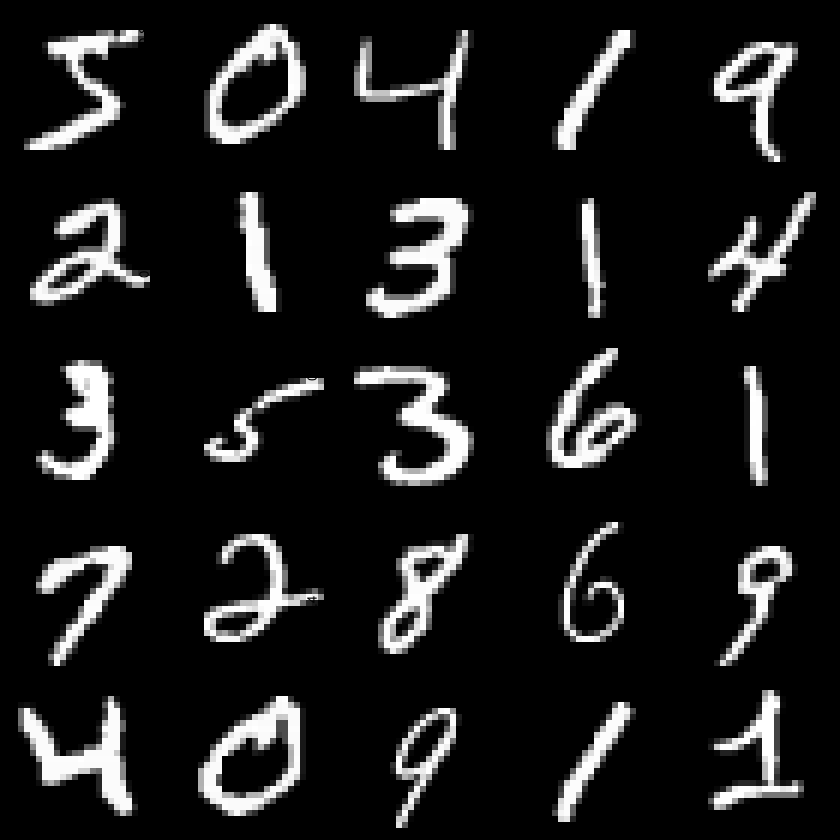

In [8]:
## DO NOT MODIFY THIS CELL
## quick sanity checking
print(train.X[10:15,20:15,3]) ## print some part of the large 3-d array
## draw first 25 images: note that the images are mirrored in columns
par(mfrow=c(5,5))
par(mar=c(0,0,0,0))
for(i in 1:25) { image(train.X[,28:1,i],col=gray((0:255)/255)) }

In [9]:
## DO NOT MODIFY THIS CELL
summary(train.X) ## show the summary of pixel-wise intensities
table(train.Y)   ## show the distribution of each digit

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00    0.00    0.00   33.32    0.00  255.00 

train.Y
   0    1    2    3    4    5    6    7    8    9 
5923 6742 5958 6131 5842 5421 5918 6265 5851 5949 

## Task 1 : Binary classification of MNIST data

The first task is to implement an algorithm that performs binary classification of MNIST images. 
1. Subset images/labels that contains only two labels (you may select a pair of digits: default is 0 and 1).
2. Example code will show how to classify images with logistic Ridge regression using `glmnet()` package.
3. You are required to implement logistic Ridge regression by using the L-BFGS-B algorithm implemented in `optim()` function.
  * You need to comment your code well and write a brief documentation to explain how you implemented it.
  * The instructors will review your code and may provide specific comments. 
4. You are encouraged to perform additional follow-ups. Examples include the following:
  * (Easy) Try different pairs of labels to understand the data-dependent differences in the classification performance.
  * (Medium) Use different objective functions (e.g. LASSO) or optimization methods (e.g. Nelder-Mead) and see how those methods perform in terms of accuracy and computational efficiency. 
  * (Hard) Try to implement multi-class classification algorithm from scratch. You may choose 3 or more (up to 10!) digits to classify simultaneously. Clearly describe what your objective function is and how you optimized it.

### Preparing input data for binary classification

The function below help you reshape the original data into a format that is easy to apply a binary classification algorithm. You are expected to specify a pair of digits as positive and negative labels. The function `prep_binary_classification()` returns a list containing a matrix `X` and a vector `y` as attributes. The matrix `X` has 784 (=28 x28) columns, and the number of rows equivalent to the number of positive + negative labels. The vector `y` is encoded as either 1 (for positive label) or 0 (for negative label) 

In [10]:
## DO NOT MODIFY THIS CELL
## prepare a model given a pair of digits
#' @param images - (r * c * n) array containing n images
#' @param labels - Size n vector of containing n labels
#' @param posLabel - The label(s) considered as positive label 
#' @param negLabel - The label(s) considered as negative label
#' @return A list containing then following attributes
#'         * X - Matrix of (nrow=number of selected labels, ncol=r*c)
#'         * y - Vector labels, encoded as zeros (negative) and ones (positive)
prep_binary_classification = function(images, labels, posLabel = 1, negLabel = 0) {
  dims = dim(images)
  X.pos = t(matrix(images[,,labels %in% posLabel],nrow=dims[1]*dims[2])) ## 784 * n1 matrix
  X.neg = t(matrix(images[,,labels %in% negLabel],nrow=dims[1]*dims[2])) ## 784 * n1 matrix
  return(list(X=rbind(X.pos, X.neg),y = c(rep(1,nrow(X.pos)),rep(0,nrow(X.neg)))))
}

In [11]:
## DO NOT MODIFY THIS CELL - IF YOU WANT TO CHANGE LABELS, USE TASK 1b.
## Subsample training and test datasets
trn = prep_binary_classification(train.X, train.Y, 1, 0)
tst = prep_binary_classification(test.X, test.Y, 1, 0)
## Check the dimensions of the data
print(dim(trn$X))
print(length(trn$y))
print(dim(tst$X))
print(length(tst$y))

[1] 12665   784
[1] 12665
[1] 2115  784
[1] 2115


### Pre-task: Perform logistic Ridge regression using `glmnet`

We will first use logistic ridge regression implemented in `glmnet` package to fit the data, to illustrate what a reasonable regression model is expected to behave. 

Let $\boldsymbol{x}_i$ be a row of `X`, and $\sigma(z) = \frac{1}{1+e^{-z}}$. Briefly, logistic Ridge regression will attempt to maximum the following penalized likelihood function.

$$
\log L(\boldsymbol{\beta},\lambda) = \frac{1}{n}\sum_{i=1}^n \left[y_i\log\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right) + (1-y_i)\log\left(1-\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)\right) \right] - \frac{\lambda}{2n}\|\boldsymbol{\beta}\|_2^2
$$

which is equivalent to minimize $-\log L(\boldsymbol{\beta},\lambda)$. The `glmnet()` function provides an easy way to perform the Ridge regression as follows:

In this exercise below, to save the computational time, we will <u>train the model using the ***test*** data</u> instead of the training data because test data is smaller in size. We will evaluate the model across all train data.

In [12]:
## DO NOT MODIFY THIS CELL
## Train the model
tic <- proc.time()
## alpha=0 : Ridge regression, lambda=1 is a regularization parameter
## Note that we are training with test data to save computational time.
ridge.fit <- glmnet(tst$X, tst$y, family="binomial", alpha = 0, lambda = 1) 
toc <- proc.time()
## Report the elapsed time
cat(paste0("Ridge regression train took ",sprintf("%.5f",(toc-tic)[3])," seconds\n")) 

Ridge regression train took 0.31500 seconds


You can evaluate the accuracy of your classification results by comparing the predicted probability with the actual labels.

In [13]:
## DO NOT MODIFY THIS CELL
## Evaluate the prediction accuracy using train data (as test data was used for training)
ridge.pred <- predict(ridge.fit, trn$X, type="response") 
## Tabulate the TP/FP/TN/FN
print(data.frame(pred=as.integer(ridge.pred > 0.5), true=trn$y) %>% count(true,pred) %>% mutate(freq=n/sum(n)))

# A tibble: 4 x 4
   true  pred     n     freq
  <dbl> <int> <int>    <dbl>
1     0     0  5885 0.465   
2     0     1    38 0.00300 
3     1     0    10 0.000790
4     1     1  6732 0.532   


### ***TASK 1a: IMPLEMENT LOGISTIC RIDGE REGRESSION ON YOUR OWN*** (required)

The goal of the first project is to implement logistic regression on your own. Here is a basic guideline.
* You need to implement `my.ridge.fit(X, y, lambda=1)` using only `base` and `stats` package.
* The function should return a list, including at least the following two attributes:
  * `par` : A vector of coefficients from logistic ridge regression with size `ncol(X)`
  * `counts` : Evaluates how many times the objective functions and gradients are evaluated.
  * Note that these attributes can be easily obtained from the output of `stats::optim()` function.  
* Using `stats::optim()` function with `L-BFGS-B` algorithm is highly recommended.
* Use $-\log L(\boldsymbol{\beta},\lambda)$ as the objective function and provide the gradient as needed.  

* For this required task, you are not allowed to use external libraries beyond default R packages (e.g. `base`, `utils`, `stats`).

#### <u>PART I - DESCRIPTION OF YOUR IMPLEMENTATION (WRITE ON YOUR OWN)</u>

#### `my.ridge.fit()`

1. The penalized log-likelihood function of logistic Ridge regression  

Let $\boldsymbol{x}_i$ be a row of `X`, and $\sigma(z) = \frac{1}{1+e^{-z}}$. Briefly,  will attempt to maximum the following penalized log-likelihood function.

$$
\log L(\boldsymbol{\beta},\lambda) = \frac{1}{n}\sum_{i=1}^n \left[y_i\log\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right) + (1-y_i)\log\left(1-\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)\right) \right] - \frac{\lambda}{2n}\|\boldsymbol{\beta}\|_2^2
$$

To maximize the likelihood function value is equivalent to minimize $-\log L(\boldsymbol{\beta},\lambda)$. 


2. Derive the gradient of the penalized log-likelihood function.   

Based on the expression above,we can derive the gradient of log-likelihood function on $\beta$ as:

$$
\frac{\partial\log L(\boldsymbol{\beta},\lambda)}{\partial \beta} = \frac{1}{n}\sum_{i=1}^n \left[y_i \frac{\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)'}{\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)} + (1-y_i)\frac{-\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)'}{1-\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)}\right] - \frac{\lambda}{n}\boldsymbol{\beta}
$$
Where $\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)'$= ${\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)}^2e^{-\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)}$=$\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)(1-\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right))$, which is the the gradient of $\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)$

3. Description on my function:   

The function `my.ridge.fit()` consists of three main parts:  
 - Contruct `fr()` function:  
 
 For this part, the log-likelihood function in part (1) is written and computed based on matrix operations in R. However, the return value of `fr()` is the negetive value of the log-likelihood function because `L-BFGS-B` algorithm is intended for minimization problems.  
 
 It's also worth noting that the clip value is applied on $\boldsymbol{x}_i^T\boldsymbol{\beta}$ to prevent the occurence of *Inf* of $\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)$ when $\boldsymbol{x}_i^T\boldsymbol{\beta}$ is negetive and has a relatively large absolute value.  
 
 In this case, values in $\boldsymbol{x}_i^T\boldsymbol{\beta}$ that are smaller than -10 are all clipped to -10, which appears to work well in the data set without introducing notable bias to the estimate of `fr()`.  
 
 - Contruct `grr()` function:  
 
  The gradient of log-likelihood function on $\beta$ in part (2) is written and computed based on matrix operations in R. The return value of `grr()` is also the negetive value of the gradient of log-likelihood function.  
  
 - Optimize target function using `stats::optim()` function with `L-BFGS-B` algorithm
 
 Using stats::optim() function with parameters (fr, grr, L-BFGS-B).  
 
The return of `my.ridge.fit()` is a list containing the two attributes `par`and `counts`, which are the estimate of coefficients from logistic ridge regression and 
 the number of function calls made on objective function and gradients. With `par`, predictions are attainable on new data of $ X $.

#### <u>PART II - ACTUAL IMPLEMENTATION </u>

_Fill in the code in the cell below. You may add additional cells if needed._

In [14]:
##########################################################
## PLEASE MODIFY THIS CELL (or Add more cells if needed)
##########################################################
## TASK 1a: Implement my.ridge.fit() function that performs logistic regression
#' @param X - (n x p) matrix of predictor variables. Assume that intercept term is already included in the input.
#' @param y - A size n vector of zeros (negative) and ones (positives) as labels.
#' @return A list containing at least the following two attributes, which can be passed from stats::optim()
#'    * par - A size p vector of coefficients from logistic ridge regression.
#'    * counts - The number of function calls made on objective function and gradients.
#'    * You may include other attributes as you want.  

# 1.deduction on fr and grr
# 2. explosion => clip value
# 3. starting point(beta) and clip values
my.ridge.fit = function(X, y, lambda=1) {
  ## IMPLEMENT YOUR OWN FUNCTION HERE:
  ## * Note that you may have to deal with numerical precision challenges.
  n <- dim(X)[1]
  p <- dim(X)[2]
  best_beta = rep(1,p)#
  sigma <- function(x){1/(1 + exp(-x))}
  sigma_p <- function(x){sigma(x)^2 * exp(-x)}
    
#  5th version     
fr <- function(x) {   ## -log likelihood function
    c_val = 10
    Xx = X %*% x
    Xx_clip = ifelse(Xx <= -c_val, - c_val, ifelse(Xx >= c_val, c_val, Xx))
    mat_sigma = sum((y-1) * Xx) - sum(log(1 + exp(-Xx_clip)))
    log_lh = mat_sigma/n - lambda*crossprod(x)/(2*n)
    return(-log_lh)
     }

# 3rd version
grr <- function(x) { ## Gradient of 'fr'
     c_val = 10
     Xx = X %*% x
     Xx_clip = ifelse(Xx <= -c_val, - c_val, ifelse(Xx >= c_val, c_val, Xx))
     mat_y = (y - sigma(Xx_clip)) # n*1
     mat_sigma =  matrix(mat_y,1,n) %*% X
     log_lh_g = (mat_sigma - lambda*x)/n # p*1
     return(-log_lh_g)
    }
    
  result = optim(best_beta, fr, grr, method = "L-BFGS-B")#
  return(list(par=result$par, counts=result$counts)) ## Make sure to return a list
}

### Evaluation of TASK 1a

***DO NOT MODIFY the code fragment below.*** 

This code evaluates your output from your previous function. 

In [15]:
## DO NOT MODIFY THIS CELL
tic <- proc.time()
rst <- my.ridge.fit(cbind(1,tst$X), tst$y, 1) ## run the new method
toc <- proc.time()
cat(paste0("New ridge regression train took ",sprintf("%.5f",(toc-tic)[3])," seconds\n")) 
cat(paste0("Number of (function, gradient) evaluations: (",rst$counts[1],",",rst$counts[2],")\n")) 
## Example output is given below.

New ridge regression train took 0.41600 seconds
Number of (function, gradient) evaluations: (60,60)


In [16]:
## DO NOT MODIFY THIS CELL
## Evaluate the prediction accuracy using train data (as test data was used for training)
sigmoid <- function(x) 1/(1+exp(-x))
my.pred <- sigmoid(cbind(1,trn$X) %*% rst$par) 
## Tabulate the TP/FP/TN/FN
print(data.frame(pred=as.integer(my.pred > 0.5), true=trn$y) %>% count(true,pred) %>% mutate(freq=n/sum(n)))
## Example output is given below.

# A tibble: 4 x 4
   true  pred     n     freq
  <dbl> <int> <int>    <dbl>
1     0     0  5912 0.467   
2     0     1    11 0.000869
3     1     0    40 0.00316 
4     1     1  6702 0.529   


#### <u>PART III - INTERPRET EVALUATION RESULTS (WRITE ON YOUR OWN)</u>

_Briefly describe the followings: (it does not have to be long. 1-2 sentences each is fine.)_
* _Does your result make sense, in terms of speed and accuracy?_  

  The result appears make good sense. The new ridge regression train took 0.414 seconds, and the accuracy reaches to approxiamtely 99.6%.  
  
 
* _What was the tricky part in your implementation? How did you address the challenges?_  

   The tricky part is the occurence of *Inf* for  $\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)$ when $\boldsymbol{x}_i^T\boldsymbol{\beta}$ is negetive and has a relatively large absolute value.
   To solve this problem, I used the clip value technique on $\boldsymbol{x}_i^T\boldsymbol{\beta}$. To be specific,  values in $\boldsymbol{x}_i^T\boldsymbol{\beta}$ that are smaller than -10 are all clipped to -10. It appears that this clip helps a lot on the explosion of the value. 
  
 
* _How could your implementation be potentially improved?_  
  
  I think there should be better ways to address the problem of the explosion of $\sigma\left(\boldsymbol{x}_i^T\boldsymbol{\beta}\right)$ when $\sigma$ is very large. For the clip-value method, bias is introduced into the the estiamte of the likelihood function.

### ***TASK 1b: EXPLORE MORE ON MNIST CLASSIFICATION ON YOUR OWN*** (optional)

This is an open-ended task. You are encouraged to perform additional follow-ups on classification. Examples include the following:
  * (Easy) Try different pairs of labels to understand the data-dependent differences in the classification performance.
  * (Medium) Use different objective functions (e.g. LASSO) or optimization methods (e.g. Nelder-Mead) and see how those methods perform in terms of accuracy and computational efficiency. 
  * (Hard) Try to implement multi-class classification algorithm from scratch. You may choose 3 or more (up to 10!) digits to classify simultaneously. Clearly describe what your objective function is and how you optimized it.

Add additional code or text cells as needed below. Make sure to include your brief report on your work so that instructors can understand what you accomplished clearly.

For this optional task, you are allowed to use any external libraries as needed.

In [17]:
##########################################################
## PLEASE MODIFY THIS CELL (or Add more cells if needed)
## To perform TASK 1b (optional)
##########################################################

## Task 2 : Clustering of MNIST data

The second task is to implement an algorithm that performs multi-class clustering of MNIST images. 
1. Subset images/labels that contains 3 or more labels (to make the problem simple, but not too simple).
2. You are required to implement at least one type of clustering method (e.g. E-M, k-means, Louvain).
  * You need to comment your code well and write a brief documentation to explain how you implemented it.
  * The instructors will review your code and may provide specific comments. 
3. You are also encouraged to implement additional methods and perform further experiments. Examples include the following:
  * (Easy) Try different sets of labels to understand the data-dependent differences in the clustering performance. Also, try to evaluate the robustness of your algorithm based on different initial points.
  * (Medium) Try to implement an algorithm that automatically select the optimal number of clusters depending on the data.
  * (Hard) Try to implement another algorithm and compare the performance between the algorithms. Describe which ones are better in which cases and justify your answer.

### Pre-task: Prepare the data for clustering

This section select a subset of labels from the test data (we work on test data rather than training to reduce response time), and cluster the corresponding images without using the labels at all. In this example, three labels - 0, 1, 2 are selected. 

In [18]:
## DO NOT MODIFY THIS CELL
## prepare data given a set of digits
#' @param images - (r * c * n) array containing n images
#' @param labels - Size n vector of containing n labels
#' @param selectedLabels - The label(s) considered for clustering  
#' @return A list containing then following attributes
#'         * X - Matrix of (nrow=number of selected labels, ncol=r*c)
#'         * y - Vector selected labels
prep_multiway_clustering = function(images, labels, selectedLabels) {
  dims = dim(images)
  idx = which(labels %in% selectedLabels)
  X = t(matrix(images[,,idx],nrow=dims[1]*dims[2])) ## 784 * n matrix
  return(list(X=X,y = labels[idx]))
}

In [19]:
# DO NOT MODIFY THIS CELL
## Select 3 labels for clustering
selectedLabels = c(0,1,2)
tst = prep_multiway_clustering(test.X, test.Y, selectedLabels)

### ***TASK 2a: IMPLEMENT 3-CLASS CLUSTERING ON YOUR OWN*** (required)

The goal of the first project is to implement 3-class clustering. Here is a basic guideline.
* You need to implement `my.clustering(X, nclust, max.iter, tol)` using only `base` and `stats` package.
* The function should return a list, including at least the following two attributes:
  * `mu` : A `ncol(X) * nclust` matrix of mean pixel strength (0-1 scale)  for each cluster. 
  * `est` : The best guess cluster of each image to one of the labels (i.e. in `1:nclust`). Note that the cluster id and the images labels do not have direct correspondence and may be permuted in different runs.
* For this required task, you are not allowed to use external libraries beyond default R packages (e.g. `base`, `utils`, `stats`). However, if you want to use algorithms based on nearest neighbors, you are allowed to use `RcppAnnoy` package. If you really have to import additional libraries, consult with your instructors beforehand.
* If you do not know what to choose, implementing an E-M algorithm may be a safe option that the instructors can give useful inputs. 

#### <u>PART I - DESCRIPTION OF YOUR IMPLEMENTATION (WRITE ON YOUR OWN)</u>

#### `my.clustering(X, nclust, max.iter=1000L, tol=1e-5)`

1. Basic description on `my.clustering()`
  My function `my.clustering()` is constructed primarily based on EM algorithm with a mixture of Bernoulli distribution.   
  
  The input includes `X`(the original n * 784 matrix of images), `nclust` (number of clusters to generate), `max.iter`(maximum number of iteration) and `tol`(tolerance to define convergence).  
  
  In the function body, firstly, the values in `X` are  binarized to 0-1, which corresponds to the Bernoulli distribution. Then EM algorithm is implemented on the the binary data with the pre-specified parameter `nclust` via `binMixEm()`,  which gives an output of a list containing all the useful results yieldes by the EM algorithm. Finally, the predictions for classification of each image(row) in the training set is computed using the output `prob_mat` from `binMixEm()`.
 
 
2. Mathematical formulation of EM algorithm with a mixture of Multivariate Bernoulli distribution  

    - Likelihood function 
        - Complete-data likelihood  
    $L(\theta) = p(\boldsymbol{x},\boldsymbol{z}|\theta) \\
    = \prod_{i=1}^n \pi_{z_i} P(\boldsymbol{x_i}|\boldsymbol{p}_{z_i}) \\
    = \prod_{c=1}^k  \prod_{i=1}^n \left\{\pi_{z_i} P(\boldsymbol{x_i}|\boldsymbol{p}_{z_i})\right\}^{I_{z_i=c}} \\
    = \prod_{c=1}^k \prod_{i=1}^n  \left\{\pi_{z_i} \prod_{j=1}^{784} { P({x_{i,j}}|{p}_{{z_{i}},j})}\right\}^{I_{z_i=c}}\\
    $
    where:  
    $\boldsymbol{x}$ is a $n * 784$ binary matrix represents the data $X$.  
    $\boldsymbol{z}$ is a $n$ matrix represents the cluster number that each row in  $X$ belongs to.  
    $\boldsymbol{x_i}$ is a $1 * 784$ vector of independent random variables that follow Bernoulli distributions with different parameters.   
    $\boldsymbol{p}_{z_i}$ is thus also a $1 * 784$ vector corresponding to the parameters of each Bernoulli distribution in $\boldsymbol{x_i}$.   
    
        - Log-likelihood  
    $\begin{aligned}
    l(\theta) &= log L(\theta)\\
    &= log p(\boldsymbol{x},\boldsymbol{z}|\theta) \\
    &= \sum_{i=1}^n log(\pi_{z_i}) + log(P(\boldsymbol{x_i}|\boldsymbol{p}_{z_i})) \\
    &=  \sum_{c=1}^k \sum_{i=1}^n  {I_{z_i=c}} \left\{log\pi_{z_i}+ log(P(\boldsymbol{x_i}|\boldsymbol{p}_{z_i}))\right\}\\
    &= \sum_{c=1}^k \sum_{i=1}^n {I_{z_i=c}}\left\{ {log\pi_{z_i}+ \sum_{j=1}^{784}logP({x_{i,j}}|{p}_{{z_{i}},j})}\right\}
    \end{aligned}
    $ 
    
        - EM algorigthm   

        - E-step : calculate the expectation of Log-likelihood based on current parameters
       $\begin{aligned}
       Q(\theta|\theta^{(t)}) &= E_{z|x,\theta ^{(t)}}[logP(\boldsymbol{x},\boldsymbol{z}|\theta)]  \\
       &= 
       \sum_{c=1}^k \sum_{i=1}^n P(z_i=c|x_i, p^{(t)}) \left\{ {log\pi_{z_i}+log(P(\boldsymbol{x_i}|\boldsymbol{p}_{z_i}))} \right\} \\
       &= 
       \sum_{c=1}^k \sum_{i=1}^n P(z_i=c|x_i, p^{(t)}) \left\{ {log\pi_{z_i}+\sum_{j=1}^{784} logP({x_{i,j}}|{p}_{{z_{i}},j})} \right\} 
       \end{aligned}
       $
    
     where $ P({x_{i,j}}|{p}_{{z_{i}},j})= {p}_{{z_{i}},j}^{x_{i,j}}(1-{p}_{{z_{i}},j})^{1-x_{i,j}}$ according to Bernoulli distribution.
    
     Based on Bayes' theorem, the classification probabilities(prob_mat) for 'class assignment' in this case is :
    
    $$
    \begin{aligned}
    P(z_{i}=c|x_i,\pi,p) &=\frac{P(z_{i}=c,x_i,\pi,p)}{P(x_i,\pi,p)} \\
    &= \frac{\pi_cP(\boldsymbol{x_{i}}|\boldsymbol{{p}_{c}})}{\sum_{c=1}^k \pi_cP(\boldsymbol{x_{i}}|\boldsymbol{{p}_c})} \\
    &= \frac{\pi_c\prod_{j=1}^{784}P({x_{i,j}}|{p}_{c,j})}{\sum_{c=1}^k \pi_c\prod_{j=1}^{784}P({x_{i,j}}|{p}_{c,j})}
    \end{aligned}
    $$
    
        - M-step : Update the parameters to maximize the likelihood function in E-step  
             
          In the M-step, we try to maximize the loglikelihood $Q(\theta|\theta^{(t)})$ w.r.t parameters $\boldsymbol{p}$ and $\boldsymbol{\pi}$, which can be realized by taking the derivatives of $\boldsymbol{p}$ and $\boldsymbol{\pi}$ and set them to zeros.
             

                    

- Update $\pi_{c}$ 


To get $\pi_{c}$, we first construct a Lagrange function beacause of the constraint:
$\sum_{c=1}^k \pi_c=1$.
                
$$
\begin{aligned}
L(\boldsymbol{\pi},\lambda) 
&= Q(\theta|\theta^{(t)})+ 
\lambda \left\{ \sum_{i=1}^n \pi_i-1\right\}     
\end{aligned}
$$
Then set the derivative wrt $\pi_{c}$ and $\lambda$ in $L(\boldsymbol{\pi},\lambda)$ to zero, we can get: 

$$
\begin{aligned}
\frac{L(\boldsymbol{\pi},\lambda)}{\partial \pi_{c}}
&= \frac{\sum_{i=1}^{n} P(z_{i}=c|x_i,\pi^{(t)},p^{(t)})}
{\pi_{c}} + \lambda = 0  
\rightarrow 
\pi_{c} = \frac{-\lambda}{\sum_{i=1}^{n} P(z_{i}=c|x_i,\pi^{(t)},p^{(t)})}
\\
\sum_{c=1}^k \pi_c &= 1
\end{aligned}
$$

Given that $\sum_{i=1}^{n} \sum_{c=1}^{k}P(z_{i}=c|x_i,\pi^{(t)},p^{(t)})=n$, we have:   
$$
\begin{aligned} 
\pi_{c}^{(t+1)} = \frac{\sum_{i=1}^n P(z_{i}=c|x_i,\pi^{(t)},p^{(t)})}{n}
\end{aligned}
$$

             
- Update $p_{c}$  
    *Take the derivative w.r.t $\boldsymbol{p_c}$*
             
$$
\begin{aligned}
\frac{\partial Q(\theta|\theta^{(t)}) }{\partial \boldsymbol{p}} 
             &= \frac{\sum_{c=1}^k \sum_{i=1}^n P(z_i=c|x_i, p^{(t)}) \left\{ {log\pi_{z_i}+log(P(\boldsymbol{x_i}|\boldsymbol{p}_{c}))} \right\}}{\partial \boldsymbol{p}} \\   
             &=\frac{\sum_{c=1}^k \sum_{i=1}^n  P(z_i=c|x_i, p^{(t)}) \left\{ 
             {log\pi_{z_i}
             +\boldsymbol{x_i}^T log(\boldsymbol{p}_{c})
             +{1-\boldsymbol{x_i}}^T log(1-\boldsymbol{p}_{c}) 
             }
             \right\}}{\partial \boldsymbol{p}} \\
             &= \sum_{i=1}^n P(z_i=c|x_i, p^{(t)}) \left\{ \frac{\boldsymbol{x_i}}{\boldsymbol{p}_{c}} 
             + \frac{\boldsymbol{1-x_i}}{\boldsymbol{1-p_{c}}} 
             \right\}\\
             &= \frac{\sum_{i=1}^n P(z_i=c|x_i, p^{(t)})
             (\boldsymbol{x_i-p_c})}
             {(\boldsymbol{p}_{c}) * (\boldsymbol{1-p_{c}})}
             \end{aligned}
             $$
             
where * represents element-wise multiplication between two vectors.
             
Set the numerator in the equation above to zero, we have:  
$$
             \begin{aligned}
             p_{c}^{(t+1)} &= \frac{
             \sum_{i=1}^n x_i P(z_{i}=c|x_i,\pi^{(t)},p^{(t)})
             }
             {\sum_{i=1}^n P(z_{i}=c|x_i,\pi^{(t)},p^{(t)})
             }\\
             &= \frac{\sum_{i=1}^n x_iP(z_{i}=c|x_i,\pi^{(t)},p^{(t)})}
             {n\pi_c^{(t+1)}}
             \end{aligned}
$$

3. Implementation of EM algorithm in ` my.clustering()`
  -  Class `binMixEm`
      - Parameter initialization
          - `pi_vec`: Randomly initialized and normalized with k numbers from uniform distruibution between 0 and 1
          - `mu_vec`: Initialized by the k equal-spaced quantiles from each column of the data.
      - Iterative procedure  
        Each interation consists of 4 main steps:  
        1. Update the classification probabilities and likelihood with latest parameters with the formulas in E-step above.  
        2. Update the class proportion `pi_vec` with the formula in M-step above.  
        3. Update the k*784 Bermoulli distribution parameters `p_mat` with the formula in M-step above.  
        4. Check convergence conditions.  
        
      - Expected results
        Given that EM algorithm always increases the log-likelihood in each iteration, the algorithm is expected to converge in a relatively small number of iterations.

#### <u>PART II - ACTUAL IMPLEMENTATION </u>

_Fill in the code below. You may add additional cells if needed._

In [124]:
##########################################################
## PLEASE MODIFY THIS CELL (or Add more cells if needed)
##########################################################
## Implement your own clustering algorithm
#' @param X : (n * 784) matrix of images (you may consider binarizing the matrix at X[i,j] == 128 if needed)
#' @param nclust : Number of clusters to generate
#' @param max.iter : Maximum number of iteration, may end early based on convergence criteria
#' @param tol : Parameters for determining convergence.
#' @return A list containing at least the following attributes:
#'    * mus - A [ ncol(X) * nclust ] matrix of mean pixel strength (0-1 scale)  for each cluster.
#'    * est - The best guess cluster of each image to one of the labels (i.e. in `1:nclust`). 

my.clustering = function(X, nclust, max.iter=1000L, tol=1e-5) {
    # binarizing the matrix at X[i,j] == 128   
    bin_X = ifelse(X>=128,1,0)
    # use EM algorithm to make predictions
    EM <- binMixEm$new(input_dat = bin_X, num_components = nclust)
    res_EM <- EM$run.EM(loglik_tol=tol,max_iter=max.iter)
#     plot(1:res_EM$iter, res_EM$loglik_list, type="l")
    # pi_vec # k*1    p_mat # k*784     bin_X# n * 784
    est <- apply(res_EM$prob_mat, 1, which.max)
    est <- sapply(est, function(x) c(1,2,0)[x])
    return(list(mus=t(res_EM$p_mat), est=est))
}

In [118]:
#' Create a class binMixEM
binMixEm <- setRefClass("binMixEM",
                         fields=list(k = "integer",
                                     n = "integer",
                                     dat_mat = "matrix", # n*784
                                     pi_vec = "vector", # k*1
                                     p_mat = "matrix", # k*784 ;Bernouli(p)
                                     prob_mat = "matrix", # n*k
                                     loglik = "numeric",
                                     tol = "numeric")
                       )
#' method to initialize binMixEm class (called with binMixEm$new)
#' @param input_data - data to initalize
#' @param num_components - number of components (k=3)
binMixEm$methods(initialize = function(input_dat,num_components){
  dat_mat <<- input_dat ## Use <<- to assign fields
  k <<- num_components # k=3
  n <<- length(dat_mat)
})


#' method to initialize parameters for E-M
binMixEm$methods(init.paras = function(){
    # pi_vec: k * 1
    # dat_mat: n * 784 
    # p_mat: k * 784
    # prob_mat: n * k
  tol <<- 1e-100  ## small number to avoid log(zero)  
  set.seed(1234)
  pi_vec <<- runif(3)
  pi_vec <<- pi_vec/sum(pi_vec)
#   pi_vec <<- rep(1.0/k,length=k)  ## uniform across components
  ## pick means from equal-spaced quantiles from the data
  ################################## sensitive!!
  p_mat <<- apply(dat_mat,2,function(x) quantile(x,prob=seq(1/(2*k),1-1/(2*k),length=k)                                                ))
  prob_mat <<- matrix(NA,nrow=n,ncol=k)              
  loglik <<- -Inf
})
    
    
# Check carefully!
#' E-step for E-M algorithm
  binMixEm$methods(update.prob = function(){
    ## prob_mat contains log-likelihood of each components
      ################################ ? p_mat = 0 =>+tol to avoid dat_mat=0 => -Inf
      # prob_mat:  n*k
    prob_mat <<- t(log(pi_vec+tol)+ tcrossprod(log(p_mat+tol), dat_mat) + tcrossprod(log(1-p_mat+tol), 1 - dat_mat))
    max_log_prob <- apply(prob_mat,1,max) ## local change, do not change the field value
    prob_mat <<- exp(prob_mat - max_log_prob) ## re-scale probability (important)
    sum_prob <- apply(prob_mat,1,sum)  ## sum probabilities for each observation      
    prob_mat <<- prob_mat/sum_prob      ## normalize the probability E[z|theta]  
    loglik <<- sum(max_log_prob + log(sum_prob))  ## evaluate log-likelihood
  })

    
#' M-step for E-M algorithm to update pi_vec
binMixEm$methods(update.pi = function(){
  pi_vec <<- apply(prob_mat,2,mean) #k*1
})

#' M-step for E-M algorithm to update mu_vec
binMixEm$methods(update.p = function(){ 
    # cheack dim(p_mat) = k * 784
#   p_mat <<- (crossprod(prob_mat,dat_mat)/ n)/(pi_vec+tol) 
    p_mat <<- (crossprod(prob_mat,dat_mat)/ apply(prob_mat,2,sum))
})

                 
#' check convergence of mixture binomial EM
binMixEm$methods(check.tol = function(fmax,fmin,ftol){
  delta = abs(fmax - fmin)
  accuracy = (abs(fmax) + abs(fmin))*ftol
  return(delta < (accuracy + tol))
})  
    
#' main function for E-M algorithm
binMixEm$methods(run.EM = function(max_iter=1000L,loglik_tol=1e-5){
  convergence = 1L
  init.paras()  ## initialize parameter
  loglik_list = NULL
  for(iter in 1:max_iter){
#     print(iter)
    loglik0 <- loglik ## log-likelihood of previous steps
    update.prob() # E-step
    update.pi()   # M-step for pi_vec
    update.p()   # M-step for p_mat
    loglik_list = c(loglik_list,loglik) # append log-likelihood
    if(check.tol(loglik0,loglik,loglik_tol)){
      convergence = 0 # converged
      break
    }
  }
  return(list(convergence=convergence,p_mat=p_mat,
              pi_vec=pi_vec,iter=iter,loglik_list=loglik_list,
              prob_mat=prob_mat))
  })



### Evaluation of TASK 2a

<u>***DO NOT MODIFY The code fragment below.***</u> 

This code evaluates your output from your previous function. 

In [125]:
## DO NOT MODIFY THIS CELL
## Run the clustering algorithm from the selected Data
tic()
rst = my.clustering(tst$X,length(selectedLabels))
toc()

1.097 sec elapsed


ERROR: Error in value[[3L]](cond): invalid graphics state


plot without title

NULL

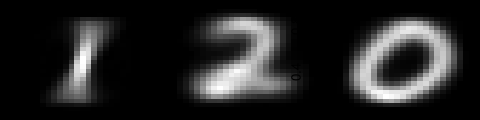

In [116]:
## DO NOT MODIFY THIS CELL
## Visualize rst$mus as images.
options(repr.plot.width=4, repr.plot.height=1)
par(mfrow=c(1,3))
par(mar=c(0,0,0,0))
apply(rst$mus,2,function(x) { image(matrix(x,28,28)[,28:1]*255,col=gray((0:255)/255)) })
## below is a result from a working example with an E-M algorithm

In [117]:
## DO NOT MODIFY THIS CELL
## Tabulate the contingency tables to understand the accuracy 
print(data.frame(est=rst$est, true=tst$y) %>% count(true,est) %>% mutate(freq=n/sum(n)))
## below is a result from a working example with an E-M algorithm

# A tibble: 8 x 4
   true   est     n    freq
  <int> <dbl> <int>   <dbl>
1     0     0   951 0.302  
2     0     1     8 0.00254
3     0     2    21 0.00667
4     1     1  1063 0.338  
5     1     2    72 0.0229 
6     2     0    38 0.0121 
7     2     1    25 0.00794
8     2     2   969 0.308  


#### <u>PART III - INTERPRET EVALUATION RESULTS (WRITE ON YOUR OWN)</u>

<u>***Please delete the text in this cell and fill in with your own.***</u>

_Briefly describe the followings: (it does not have to be long. 1-2 sentences each is fine._
* _Does your result make sense, in terms of speed and accuracy?_  

  The result appears make sense, which can be directly visualized by the image above. It usually takes less than 2 seconds to converge in the algorithm above, and the accuracy over the three group is approxiamtely 94%.  
  
 
* _What was the tricky part in your implementation? How did you address the challenges?_  

   The tricky part is the calculation of log-likehood in `update.prob()`. In the case of Bernoulli distribution, the log of $ P({x_{i,j}}|{p}_{{z_{i}},j})= {p}_{{z_{i}},j}^{x_{i,j}}(1-{p}_{{z_{i}},j})^{1-x_{i,j}}$ could be -Inf when the parameter ${p}_{{z_{i}},j}$ equals 1 or 0. To address this problem, I add a tolerance term `tol=1e-100` so that $log({p}_{{z_{i}},j}+tol)$ would be a finite negative number instead of -Inf, which helps to settle the problem well.
  
 
* _How could your implementation be potentially improved?_  
  
  I believe that the accuracy of classification can be further improved. 
  In the case of the classification of data with labels (0,1,2), the inaccuracy is introduced by the confusion between '1' and '2'. This can be a start point for further improvements focusing on distinguish them.


### ***TASK 2b: EXPLORE MORE ON MNIST CLUSTERING ON YOUR OWN*** (optional)

This is an open-ended task. You are encouraged to perform additional follow-ups on clustering. Examples include the following:
  * (Easy) Try different sets of labels to understand the data-dependent differences in the clustering performance. Also, try to evaluate the robustness of your algorithm based on different initial points.
  * (Medium) Try to implement an algorithm that automatically select the optimal number of clusters depending on the data.
  * (Hard) Try to implement another algorithm and compare the performance between the algorithms. Describe which ones are better in which cases and justify your answer.

Add additional code or text cells as needed below. Make sure to include your brief report on your work so that instructors can understand what you accomplished clearly.

For this optional task, you are allowed to use any external libraries as needed.

In [25]:
##########################################################
## PLEASE MODIFY THIS CELL (or Add more cells if needed)
## To perform TASK 2b (optional)
##########################################################